In [8]:
# Load your dataset
import pandas as pd
df = pd.read_csv(r'C:\Dataset-python.csv')

# Calculating Recency
from datetime import datetime

# Assume 'Date' column is in 'YYYY-MM-DD' format
df['Date'] = pd.to_datetime(df['Date'])

# Find the latest date in the dataset
latest_date = df['Date'].max()

# Calculating Recency, frequency, monetary
recency = df.groupby('CustomerID')['Date'].apply(lambda x: (latest_date - x.max()).days).reset_index()
recency.columns = ['CustomerID', 'Recency']
frequency = df.groupby('CustomerID')['OrderID'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']
monetary = df.groupby('CustomerID')['Revenue'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Combining RFM metrics
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

# RFM Scoring
rfm['Recency_rank'] = rfm['Recency'].rank(method='max')
rfm['Recency_Score'] = pd.cut(rfm['Recency'], bins=4, labels=[4, 3, 2, 1])
rfm['Frequency_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['RFM_Segment'] = rfm['Recency_Score'].astype(str) + rfm['Frequency_Score'].astype(str) + rfm['Monetary_Score'].astype(str)
rfm['RFM_Score'] = rfm[['Recency_Score', 'Frequency_Score', 'Monetary_Score']].sum(axis=1)
# print(rfm.head(10))

In [4]:
from sklearn.preprocessing import StandardScaler

# Select only the RFM columns for scaling
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]

# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_data)


In [5]:
from sklearn.cluster import KMeans

# Choose the number of clusters (K)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model
kmeans.fit(rfm_normalized)

# Add the cluster labels to the original RFM DataFrame
rfm['Cluster'] = kmeans.labels_


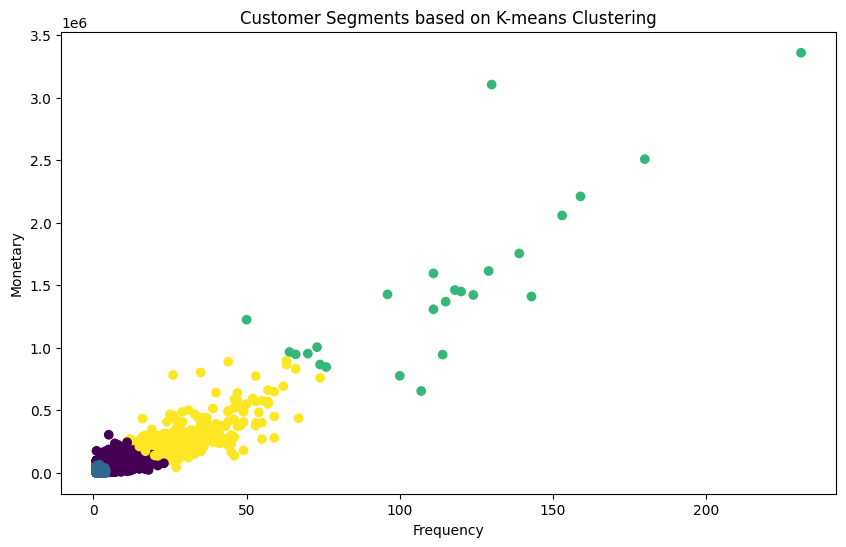

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments based on K-means Clustering')
plt.show()


In [7]:
# Calculate Customer Lifetime Value (CLV)
avg_purchase_value = df['Revenue'].mean()
purchase_frequency = df.groupby('CustomerID')['OrderID'].count().mean()
customer_lifespan = 3  # assuming 3 years
clv = avg_purchase_value * purchase_frequency * customer_lifespan
print(f"Customer Lifetime Value: {clv}")

# Calculate Average Revenue Per User (ARPU)
total_revenue = df['Revenue'].sum()
num_users = df['CustomerID'].nunique()
arpu = total_revenue / num_users
print(f"Average Revenue Per User: {arpu}")

Customer Lifetime Value: 26721.890800311667
Average Revenue Per User: 8907.296933437221
